In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from tensorflow.keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [136]:
df = pd.read_csv(r'cell2celltrain.csv')
df.shape

(51047, 58)

In [137]:
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [139]:
df.columns

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

In [389]:
#df_graph = df[['CustomerID', 'Churn', 'ServiceArea', 'HandsetModels', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'PrizmCode', 'Occupation']].copy()
df_graph = df[['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge']].head(100).copy()
df_graph = df_graph.dropna()
df_graph.Churn[df_graph.Churn =='Yes'] = int(1)
df_graph.Churn[df_graph.Churn =='No'] = int(0)
df_graph["Churn"] = df_graph["Churn"].astype(int)
print(df_graph.shape)
df_graph.dtypes

(100, 5)


C:\Users\Sandeep\Anaconda3\envs\dl_ver\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Sandeep\Anaconda3\envs\dl_ver\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


CustomerID                int64
Churn                     int32
MonthlyRevenue          float64
MonthlyMinutes          float64
TotalRecurringCharge    float64
dtype: object

In [390]:
df_graph.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge
0,3000002,1,24.00,219.0,22.0
1,3000010,1,16.99,10.0,17.0
2,3000014,0,38.00,8.0,38.0
3,3000022,0,82.28,1312.0,75.0
4,3000026,1,17.14,0.0,17.0


In [391]:
Graphtype = nx.Graph()
gx = nx.from_pandas_edgelist(df_graph, source='CustomerID', target='CustomerID', create_using=Graphtype)

In [392]:
print(gx.number_of_edges(), gx.number_of_nodes())

100 100


In [393]:
# Set the dataframe index to be the same as the user_id and drop the user_id columns
#df_graph.index = df_graph.index.map(str)
df_graph.set_index("CustomerID", inplace = True)
#df_graph.drop(columns=["CustomerID"], inplace=True)

In [394]:
df_graph.dtypes

Churn                     int32
MonthlyRevenue          float64
MonthlyMinutes          float64
TotalRecurringCharge    float64
dtype: object

In [395]:
df_graph.head()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge
CustomerID,,,,
3000002,1,24.00,219.0,22.0
3000010,1,16.99,10.0,17.0
3000014,0,38.00,8.0,38.0
3000022,0,82.28,1312.0,75.0
3000026,1,17.14,0.0,17.0


In [396]:
# choose the nodes annotated
annotated_users = df_graph
annotated_user_features = annotated_users.drop(columns=["Churn"])
annotated_user_targets = annotated_users[["Churn"]]
print(annotated_user_targets.Churn.value_counts())

0    72
1    28
Name: Churn, dtype: int64


In [397]:
# split the data
train_data, test_data, train_targets, test_targets = train_test_split(
    annotated_user_features, annotated_user_targets, test_size=0.85, random_state=101
)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print(
    "Train data number of 0s {} and 1s {}".format(
        np.sum(train_targets == 0), np.sum(train_targets == 1)
    )
)
print(
    "Test data number of 0s {} and 1s {}".format(
        np.sum(test_targets == 0), np.sum(test_targets == 1)
    )
)

Sizes and class distributions for train/test data
Shape train_data (15, 3)
Shape test_data (85, 3)
Train data number of 0s 10 and 1s 5
Test data number of 0s 62 and 1s 23


In [398]:
print(train_targets.shape, test_targets.shape)
print(train_data.shape, test_data.shape)

(15, 1) (85, 1)
(15, 3) (85, 3)


In [399]:
# choosing features to assign to a graph, excluding target variable
node_features = df_graph.drop(columns=["Churn"])

In [400]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced", np.unique(train_targets), train_targets[:, 0]
)
train_class_weights = dict(zip(np.unique(train_targets), class_weights))
train_class_weights

{0: 0.75, 1: 1.5}

In [427]:
model_type = "gcn"#"graphsage"  # Can be either gcn, gat, or graphsage

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50
    num_samples = [20, 10]
    epochs = 30  # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    epochs = 20  # The number of training epochs
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20  # The number of training epochs

In [428]:
G = sg.StellarGraph(gx, node_features=node_features)

In [429]:
if model_type == "graphsage":
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, train_targets, shuffle=True)
elif model_type == "gcn":
    generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, train_targets,)
elif model_type == "gat":
    generator = FullBatchNodeGenerator(G, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, train_targets,)

Using GCN (local pooling) filters...


In [430]:
if model_type == "graphsage":
    """
    base_model = GraphSAGE(
        layer_sizes=[32, 32], generator=train_gen, bias=True, dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    """
      
    generator = GraphSAGENodeGenerator(G, batch_size=50, num_samples=[20,10])
    gat = GraphSAGE(
            layer_sizes=[32, 32],
            activations=["relu","softmax"],
            generator=generator,
        )
    x_inp, prediction = gat.build()
    
elif model_type == "gcn":
    base_model = GCN(
        layer_sizes=[32, 16],
        generator=generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "elu"],
    )
    x_inp, x_out = base_model.build()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == "gat":
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.build()

In [431]:
model = Model(inputs=x_inp, outputs=prediction)

In [432]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005), loss=losses.binary_crossentropy, metrics=["acc"],
)

In [433]:
model

In [434]:
test_gen = generator.flow(test_data.index, test_targets)

In [435]:
class_weight = None
if model_type == "graphsage":
    class_weight = train_class_weights
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    verbose=0,
    shuffle=False,
    class_weight=class_weight,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


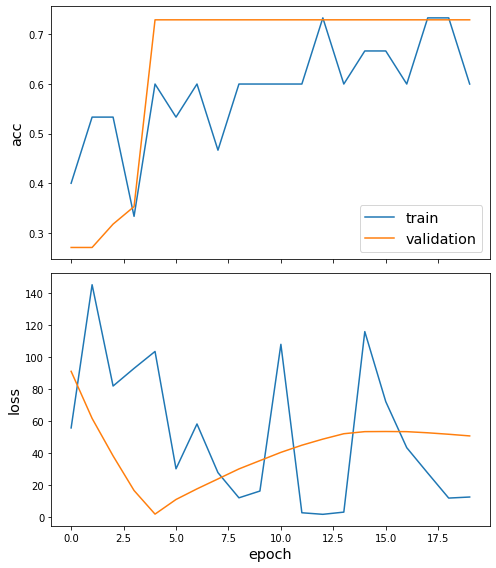

In [436]:
sg.utils.plot_history(history)

In [437]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']

Test Set Metrics:
	loss: 50.6782
	acc: 0.7294


In [438]:
all_nodes = df_graph.index
all_gen = generator.flow(all_nodes)

In [439]:
all_predictions_nondeprec = model.predict(all_gen)

In [440]:
all_predictions_nondeprec.shape

(1, 100, 1)

In [441]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [442]:
all_predictions.shape

(100, 1)

In [444]:
#all_predictions_reshaped = all_predictions.reshape(100, 32)
#all_predictions_reshaped.shape

In [448]:
all_predictions_df = pd.DataFrame(all_predictions, index=df_graph.index)

In [449]:
#Let's extract the predictions for the test data only.
test_preds = all_predictions_df.loc[test_data.index, :]

In [450]:
test_preds.shape


(85, 1)

In [451]:
#The predictions are the probability of the true class that in this case is the probability of a user being hateful.
test_preds.head()

,0
CustomerID,
3000102,5.181248e-07
3000010,5.179693e-03
3000290,9.880281e-04
3000434,0.000000e+00
3000614,0.000000e+00


In [455]:
test_predictions = test_preds.values
test_predictions_class = ((test_predictions > 0.5) * 1).flatten()
test_df = pd.DataFrame(
    {
        "Predicted_score": test_predictions.flatten(),
        "Predicted_class": test_predictions_class,
        "True": test_targets[:, 0]
    }
)
roc_auc = metrics.roc_auc_score(test_df["True"].values, test_df["Predicted_score"].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5063113604488079


In [456]:
pd.crosstab(test_df["True"], test_df["Predicted_class"])

Predicted_class,0
True,
0,62
1,23


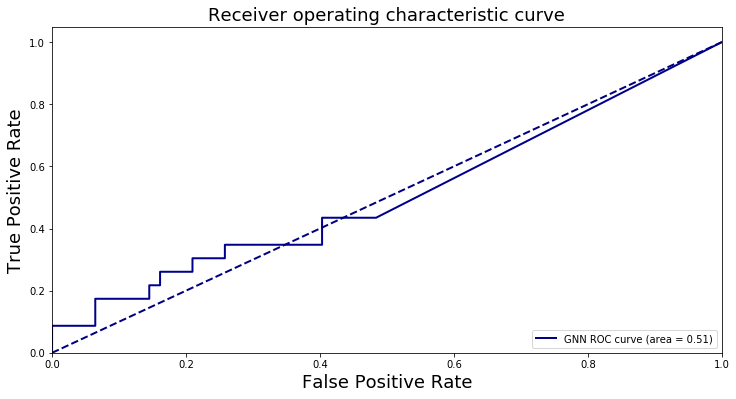

In [457]:
fpr, tpr, thresholds = metrics.roc_curve(
    test_df["True"], test_df["Predicted_score"], pos_label=1
)
plt.figure(figsize=(12, 6,))

lw = 2
plt.plot(
    fpr, tpr, color="darkblue", lw=lw, label="GNN ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Receiver operating characteristic curve", fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [458]:

model.layers

In [459]:
if model_type == "graphsage":
    # For GraphSAGE, we are going to use the output activations
    # of the second GraphSAGE layer as the node embeddings
    # x_inp, prediction
    emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
    emb = emb_model.predict_generator(generator=all_gen,)
elif model_type == "gcn":
    # For GCN, we are going to use the output activations of
    # the second GCN layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == "gat":
    # For GAT, we are going to use the output activations of the
    # first Graph Attention layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)

In [460]:
emb.shape


(1, 100, 32)

In [461]:

emb = emb.squeeze()


In [462]:
emb.shape

(100, 32)

In [463]:

if model_type == "graphsage":
    emb_all_df = pd.DataFrame(emb, index=df_graph.index)
elif model_type == "gcn" or model_type == "gat":
    emb_all_df = pd.DataFrame(emb, index=G.nodes())



In [464]:
#Select the embeddings for the test set. We are only going to visualise the test set embeddings.

emb_test = emb_all_df.loc[test_data.index, :]


In [465]:
#Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

X = emb_test
y = test_targets


In [466]:

X.shape

(85, 32)

In [467]:
transform = TSNE  # or use PCA

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed["label"] = y

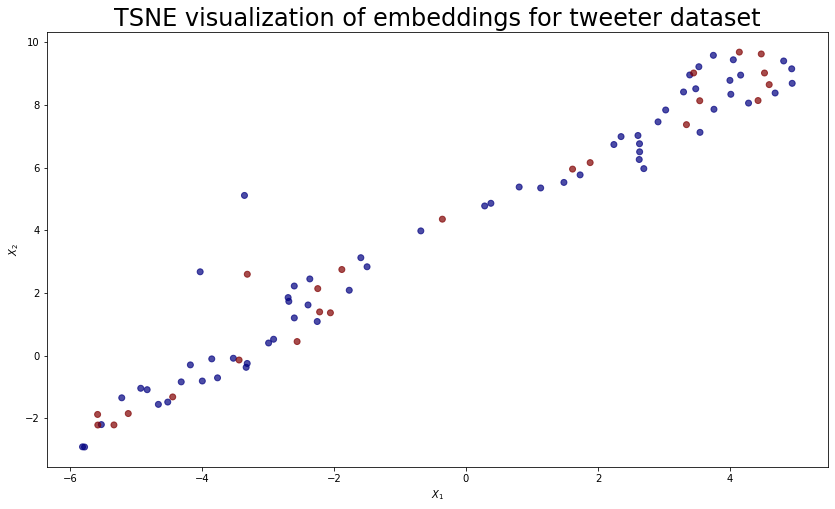

In [469]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 8,))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of embeddings for tweeter dataset".format(transform.__name__),
    fontsize=24,
)
plt.show()